### Info extraction and basic descriptives

Essential imports

In [1]:
import os
import cv2
import glob
import re
import subprocess
import pandas as pd
from moviepy.editor import VideoFileClip
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('default')  # or use another valid style like 'seaborn'

import seaborn as sns
import ffmpeg

import csv



Bad key "text.kerning_factor" on line 4 in
C:\Users\samae\anaconda3\envs\stream_board\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Setting the base path

In [2]:
base_path = r"C:/Users/samae/Documents/GitHub/GUI_pattern_generator/data/datos_tesis/videosXavy/videosPequenhos"

List all .mp4 files in the directory and its subdirectories

In [3]:
video_files = glob.glob(os.path.join(base_path, '**', '*.mp4'), recursive=True)
print(f"Number of video files found: {len(video_files)}")

Number of video files found: 184


Extract Video Information

In [4]:
video_info = []

# Regular expression to extract the date and time (with milliseconds) from the filename
filename_regex = re.compile(r'(\d{8}_\d{9})')

def fix_video(file_path):
    """
    Fix the video file using ffmpeg and faststart.
    
    Parameters:
    - file_path: str, path to the video file.
    
    Returns:
    - file_path: str, path to the fixed video file.
    """
    temp_file = file_path + '_temp.mp4'
    command = f'ffmpeg -i "{file_path}" -c copy -movflags faststart "{temp_file}" -y'
    subprocess.call(command, shell=True)
    if os.path.exists(temp_file):
        os.remove(file_path)
        os.rename(temp_file, file_path)
    return file_path


# Extracting and Fixing Video Information
for video_file in video_files:
    try:
        # Create a VideoFileClip object
        clip = VideoFileClip(video_file)
        
        # Get frame count
        frame_count = clip.reader.nframes

        # Extract the exact time of the video recording from the filename
        match = filename_regex.search(os.path.basename(video_file))
        if match:
            recording_time = match.group(1)
            # Convert the recording time to a datetime object
            recording_time_dt = datetime.strptime(recording_time, '%Y%m%d_%H%M%S%f')
        else:
            recording_time = "Unknown"
            recording_time_dt = None

        # Get video information
        duration = clip.duration  # duration in seconds
        frame_rate = clip.fps  # frames per second
        frame_size = clip.size  # size in pixels (width, height)
        file_size = os.path.getsize(video_file)  # file size in bytes

        # Calculate the end time of the video
        if recording_time_dt:
            end_time_dt = recording_time_dt + pd.Timedelta(seconds=duration)
        else:
            end_time_dt = None

        # Determine the camera angle from the file path
        if 'Frontal' in video_file:
            camera_angle = 'Frontal'
        elif 'Lateral' in video_file:
            camera_angle = 'Lateral'
        else:
            camera_angle = 'Unknown'

        # Calculate fps * frame count
        calculated_duration = frame_count / frame_rate

        # Add video information to the list
        video_info.append([
            video_file, recording_time, duration, frame_rate, 
            frame_size[0], frame_size[1], file_size, 
            camera_angle, recording_time_dt, end_time_dt, frame_count, calculated_duration, None
        ])
    except Exception as e:
        if "moov atom not found" in str(e):
            # Attempt to fix the video file
            try:
                video_file = fix_video(video_file)
                clip = VideoFileClip(video_file)
                
                # Get frame count
                frame_count = clip.reader.nframes

                # Extract the exact time of the video recording from the filename
                match = filename_regex.search(os.path.basename(video_file))
                if match:
                    recording_time = match.group(1)
                    # Convert the recording time to a datetime object
                    recording_time_dt = datetime.strptime(recording_time, '%Y%m%d_%H%M%S%f')
                else:
                    recording_time = "Unknown"
                    recording_time_dt = None

                # Get video information
                duration = clip.duration  # duration in seconds
                frame_rate = clip.fps  # frames per second
                frame_size = clip.size  # size in pixels (width, height)
                file_size = os.path.getsize(video_file)  # file size in bytes

                # Calculate the end time of the video
                if recording_time_dt:
                    end_time_dt = recording_time_dt + pd.Timedelta(seconds=duration)
                else:
                    end_time_dt = None

                # Determine the camera angle from the file path
                if 'Frontal' in video_file:
                    camera_angle = 'Frontal'
                elif 'Lateral' in video_file:
                    camera_angle = 'Lateral'
                else:
                    camera_angle = 'Unknown'

                # Calculate fps * frame count
                calculated_duration = frame_count / frame_rate

                # Add video information to the list
                video_info.append([
                    video_file, recording_time, duration, frame_rate, 
                    frame_size[0], frame_size[1], file_size, 
                    camera_angle, recording_time_dt, end_time_dt, frame_count, calculated_duration, None
                ])
            except Exception as e_fix:
                print(f"Error processing file {video_file}: {e_fix}")
                video_info.append([video_file, "Unknown", None, None, None, None, None, None, None, None, None, None, "Corrupto"])
        else:
            print(f"Error processing file {video_file}: {e}")
            video_info.append([video_file, "Unknown", None, None, None, None, None, None, None, None, None, None, str(e)])

# Create a DataFrame from the Video Information
df = pd.DataFrame(video_info, columns=[
    'File', 'Recording Time', 'Duration (s)', 'Frame Rate (fps)', 'Width (px)', 
    'Height (px)', 'File Size (bytes)', 'Camera Angle', 'Start Time', 'End Time', 
    'Frame Count', 'Calculated Duration (fps * frame count)', 'Error'
])

# Ensure Start Time and End Time are datetime and handle nulls
df['Start Time'] = pd.to_datetime(df['Start Time'], errors='coerce')
df['End Time'] = pd.to_datetime(df['End Time'], errors='coerce')

# Calculate discrepancies
df['Discrepancy (Duration vs End-Start)'] = df['Duration (s)'] - (df['End Time'] - df['Start Time']).dt.total_seconds()
df['Discrepancy (Duration vs Calculated)'] = df['Duration (s)'] - df['Calculated Duration (fps * frame count)']

# Save the DataFrame to a CSV File
output_csv_path = 'videos_preprocesados_info.csv'
df.to_csv(output_csv_path, index=False)
print(f"Video information saved to {output_csv_path}")

PermissionError: [Errno 13] Permission denied: 'videos_preprocesados_info.csv'

In [5]:
"""
# Sort the DataFrame by 'Start Time' in chronological order
df = df.sort_values(by='Start Time')


# Save the sorted DataFrame to a CSV File
output_csv_path = 'videos_preprocesados_info_cronologico.csv'
df.to_csv(output_csv_path, index=False)
print(f"Video information saved to {output_csv_path}")
"""

'\n# Sort the DataFrame by \'Start Time\' in chronological order\ndf = df.sort_values(by=\'Start Time\')\n\n\n# Save the sorted DataFrame to a CSV File\noutput_csv_path = \'videos_preprocesados_info_cronologico.csv\'\ndf.to_csv(output_csv_path, index=False)\nprint(f"Video information saved to {output_csv_path}")\n'

In [6]:
# Display the DataFrame
from IPython.display import display
display(df.head(30))

,File,Recording Time,Duration (s),Frame Rate (fps),Width (px),Height (px),File Size (bytes),Camera Angle,Start Time,End Time,Frame Count,Calculated Duration (fps * frame count),Error,Discrepancy (Duration vs End-Start),Discrepancy (Duration vs Calculated)
0,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_183354394,65.12,25.0,640,400,7426318,Frontal,2024-05-15 18:33:54.394,2024-05-15 18:34:59.514,1629,65.16,None,0.000000e+00,-0.04
1,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_183546399,120.08,25.0,640,400,12626508,Frontal,2024-05-15 18:35:46.399,2024-05-15 18:37:46.479,3003,120.12,None,-1.421085e-14,-0.04
2,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_183855914,167.16,25.0,640,400,18134967,Frontal,2024-05-15 18:38:55.914,2024-05-15 18:41:43.074,4180,167.20,None,0.000000e+00,-0.04
3,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_184436666,116.04,25.0,640,400,12676237,Frontal,2024-05-15 18:44:36.666,2024-05-15 18:46:32.706,2902,116.08,None,-1.421085e-14,-0.04
4,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_184758634,127.36,25.0,640,400,14417352,Frontal,2024-05-15 18:47:58.634,2024-05-15 18:50:05.994,3185,127.40,None,-1.421085e-14,-0.04
5,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_185240986,121.16,25.0,640,400,13944716,Frontal,2024-05-15 18:52:40.986,2024-05-15 18:54:42.146,3030,121.20,None,-1.421085e-14,-0.04
6,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_185602309,126.00,25.0,640,400,14956515,Frontal,2024-05-15 18:56:02.309,2024-05-15 18:58:08.309,3151,126.04,None,-1.421085e-14,-0.04
7,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_185909243,126.36,25.0,640,400,13622109,Frontal,2024-05-15 18:59:09.243,2024-05-15 19:01:15.603,3160,126.40,None,-1.421085e-14,-0.04
8,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_190213877,116.92,25.0,640,400,13514375,Frontal,2024-05-15 19:02:13.877,2024-05-15 19:04:10.797,2924,116.96,None,0.000000e+00,-0.04
9,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_190549463,112.96,25.0,640,400,13105854,Frontal,2024-05-15 19:05:49.463,2024-05-15 19:07:42.423,2825,113.00,None,0.000000e+00,-0.04


Displaying the descriptives

In [7]:
desc_stats = df.describe(include='all')
display(desc_stats)

# Guardar las estadísticas descriptivas en un archivo CSV
desc_stats.to_csv('descriptive_stats_preprocesados.csv')

,File,Recording Time,Duration (s),Frame Rate (fps),Width (px),Height (px),File Size (bytes),Camera Angle,Start Time,End Time,Frame Count,Calculated Duration (fps * frame count),Error,Discrepancy (Duration vs End-Start),Discrepancy (Duration vs Calculated)
count,184,184,184.000000,184.000000,184.000000,184.000000,1.840000e+02,184,184,184,184.000000,184.00000,0,1.840000e+02,184.000000
unique,184,184,NaN,NaN,NaN,NaN,NaN,2,184,184,NaN,NaN,0,NaN,NaN
top,C:/Users/samae/Documents/GitHub/GUI_pattern_ge...,20240515_183354394,NaN,NaN,NaN,NaN,NaN,Frontal,2024-05-15 18:33:54.394000,2024-05-15 18:34:59.514000,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,92,1,1,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-09 19:02:31.533000,2024-05-09 19:03:12.333000,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-28 20:36:29.650000,2024-05-28 20:38:02.388000,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,81.961087,62.500000,483.478261,556.521739,2.529498e+07,NaN,NaN,NaN,5174.456522,81.98375,NaN,-5.271146e-15,-0.022663
std,NaN,NaN,24.689791,37.602319,114.619206,114.619206,1.345787e+07,NaN,NaN,NaN,3644.581090,24.68969,NaN,6.987733e-15,0.015991
min,NaN,NaN,21.280000,25.000000,400.000000,400.000000,4.196354e+06,NaN,NaN,NaN,533.000000,21.32000,NaN,-2.842171e-14,-0.040000
25%,NaN,NaN,68.375000,25.000000,400.000000,400.000000,1.393953e+07,NaN,NaN,NaN,1931.250000,68.40750,NaN,-1.421085e-14,-0.040000


Basic statistic analysis

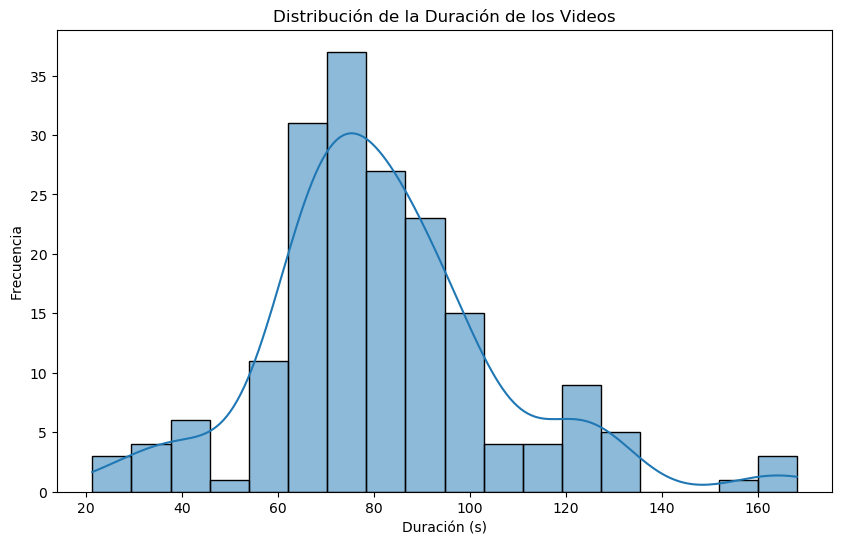

In [8]:
# Graficar la distribución de la duración de los videos
plt.figure(figsize=(10, 6))
sns.histplot(df['Duration (s)'], kde=True)
plt.title('Distribución de la Duración de los Videos')
plt.xlabel('Duración (s)')
plt.ylabel('Frecuencia')
plt.show()

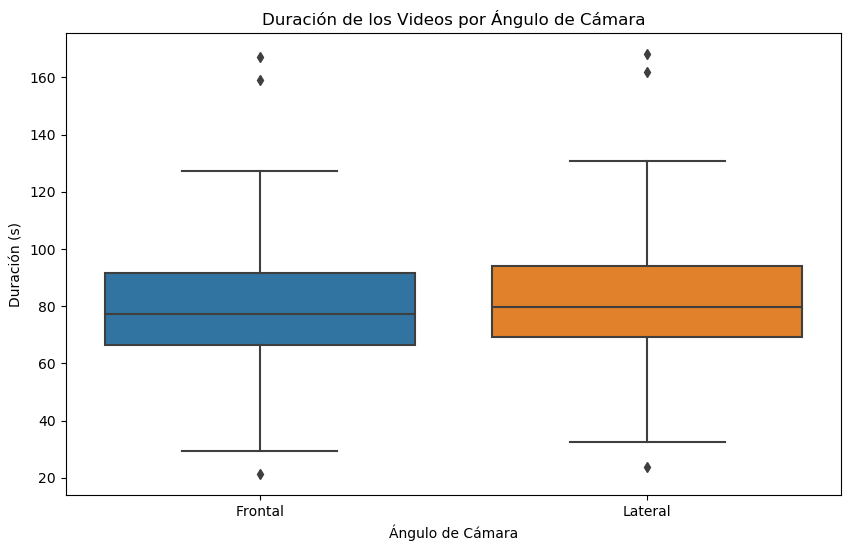

In [9]:
# Box plot de la duración de los videos por ángulo de cámara
plt.figure(figsize=(10, 6))
sns.boxplot(x='Camera Angle', y='Duration (s)', data=df)
plt.title('Duración de los Videos por Ángulo de Cámara')
plt.xlabel('Ángulo de Cámara')
plt.ylabel('Duración (s)')
plt.show()

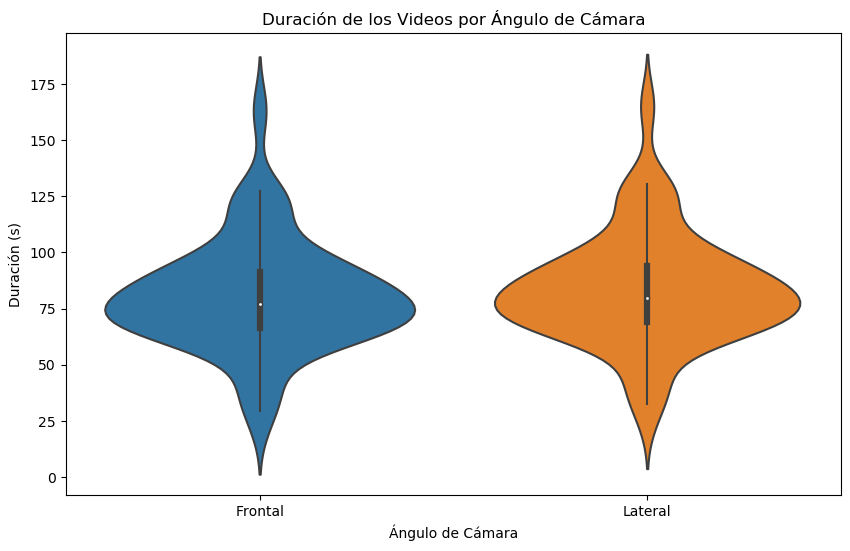

In [10]:
# Violin plot de la duración de los videos por ángulo de cámara
plt.figure(figsize=(10, 6))
sns.violinplot(x='Camera Angle', y='Duration (s)', data=df)
plt.title('Duración de los Videos por Ángulo de Cámara')
plt.xlabel('Ángulo de Cámara')
plt.ylabel('Duración (s)')
plt.show()

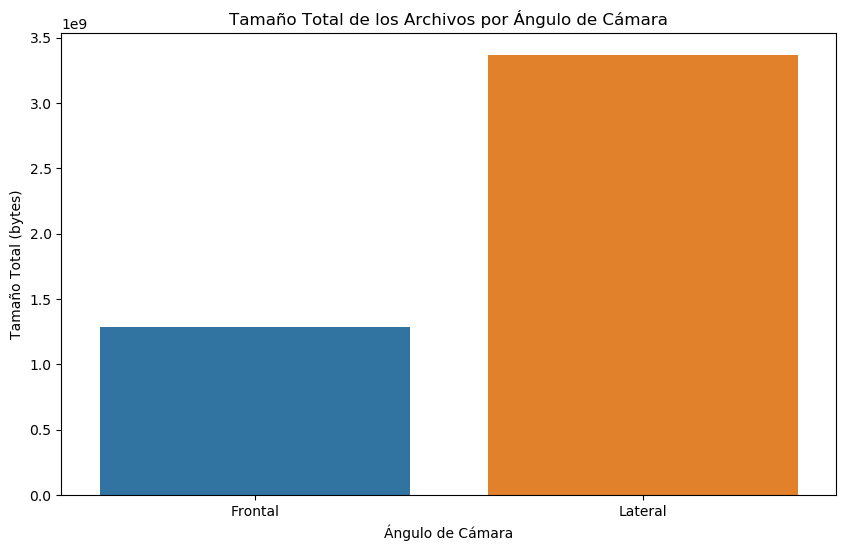

In [11]:
# Bar plot del tamaño promedio de los archivos por ángulo de cámara
plt.figure(figsize=(10, 6))
sns.barplot(x='Camera Angle', y='File Size (bytes)', data=df, estimator=sum, ci=None)
plt.title('Tamaño Total de los Archivos por Ángulo de Cámara')
plt.xlabel('Ángulo de Cámara')
plt.ylabel('Tamaño Total (bytes)')
plt.show()


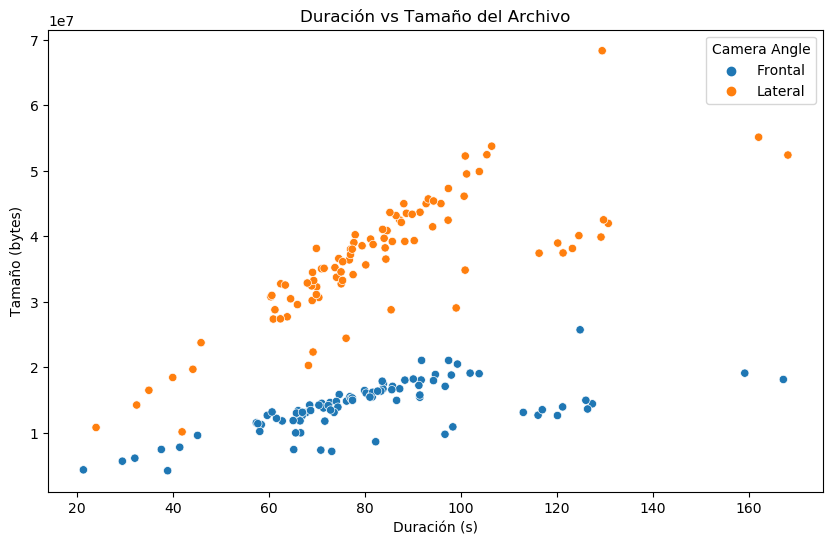

In [12]:
# Scatter plot de la duración vs el tamaño del archivo
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration (s)', y='File Size (bytes)', hue='Camera Angle', data=df)
plt.title('Duración vs Tamaño del Archivo')
plt.xlabel('Duración (s)')
plt.ylabel('Tamaño (bytes)')
plt.show()

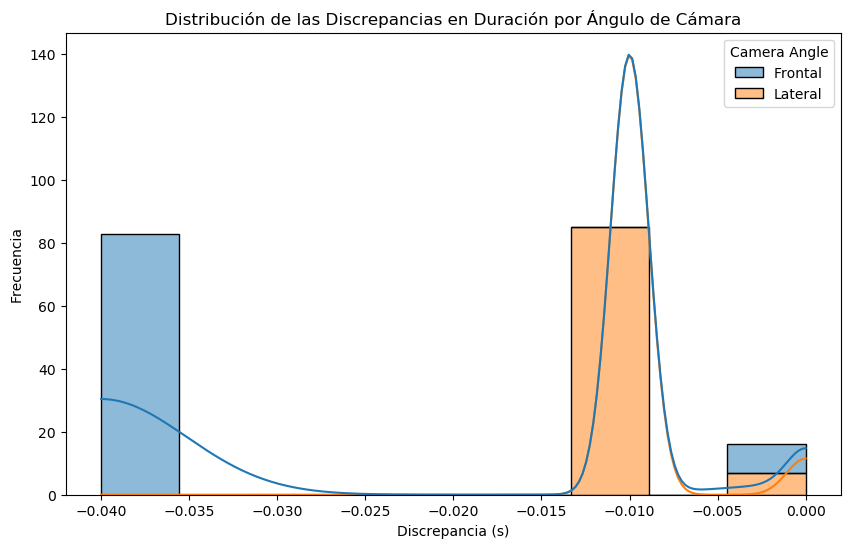

In [13]:
# Graficar la distribución de las discrepancias coloreada por ángulo de la cámara
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Discrepancy (Duration vs Calculated)', hue='Camera Angle', kde=True, multiple="stack")
plt.title('Distribución de las Discrepancias en Duración por Ángulo de Cámara')
plt.xlabel('Discrepancia (s)')
plt.ylabel('Frecuencia')
plt.show()

In [14]:
# Estadísticas descriptivas separadas por fps
fps_25 = df[df['Frame Rate (fps)'] == 25]
fps_156 = df[df['Frame Rate (fps)'] == 100]

print("Estadísticas para videos con 25 fps:")
display(fps_25.describe())

print("\nEstadísticas para videos con 100 fps:")
display(fps_156.describe())


Estadísticas para videos con 25 fps:


,Duration (s),Frame Rate (fps),Width (px),Height (px),File Size (bytes),Frame Count,Calculated Duration (fps * frame count),Discrepancy (Duration vs End-Start),Discrepancy (Duration vs Calculated)
count,92.000000,92.0,92.000000,92.000000,9.200000e+01,92.000000,92.000000,9.200000e+01,92.000000
mean,80.601739,25.0,566.956522,473.043478,1.401474e+07,2015.945652,80.637826,-4.363659e-15,-0.036087
std,24.616841,0.0,111.036467,111.036467,3.832086e+06,615.451239,24.618050,6.388011e-15,0.011948
min,21.280000,25.0,400.000000,400.000000,4.196354e+06,533.000000,21.320000,-1.421085e-14,-0.040000
25%,66.530000,25.0,400.000000,400.000000,1.211165e+07,1664.250000,66.570000,-1.421085e-14,-0.040000
50%,77.180000,25.0,640.000000,400.000000,1.418609e+07,1929.500000,77.180000,0.000000e+00,-0.040000
75%,91.470000,25.0,640.000000,640.000000,1.638159e+07,2287.750000,91.510000,0.000000e+00,-0.040000
max,167.160000,25.0,640.000000,640.000000,2.572074e+07,4180.000000,167.200000,0.000000e+00,0.000000



Estadísticas para videos con 100 fps:


,Duration (s),Frame Rate (fps),Width (px),Height (px),File Size (bytes),Frame Count,Calculated Duration (fps * frame count),Discrepancy (Duration vs End-Start),Discrepancy (Duration vs Calculated)
count,92.000000,92.0,92.0,92.0,9.200000e+01,92.000000,92.000000,9.200000e+01,92.000000
mean,83.320435,100.0,400.0,640.0,3.657521e+07,8332.967391,83.329674,-6.178632e-15,-0.009239
std,24.822272,0.0,0.0,0.0,9.604694e+06,2482.234953,24.822350,7.464687e-15,0.002666
min,23.920000,100.0,400.0,640.0,1.013325e+07,2393.000000,23.930000,-2.842171e-14,-0.010000
25%,69.245000,100.0,400.0,640.0,3.198571e+07,6925.500000,69.255000,-1.421085e-14,-0.010000
50%,79.745000,100.0,400.0,640.0,3.744337e+07,7975.500000,79.755000,0.000000e+00,-0.010000
75%,94.117500,100.0,400.0,640.0,4.221600e+07,9412.750000,94.127500,0.000000e+00,-0.010000
max,168.110000,100.0,400.0,640.0,6.834579e+07,16812.000000,168.120000,0.000000e+00,0.000000


### Segmentar los videos
Extract Time from Filenames tpg

In [18]:
import os
import cv2
from datetime import timedelta
import re
from moviepy.editor import VideoFileClip
import pandas as pd

def extract_time_from_filename(filename):
    match = re.search(r'_(\d{9})(?:_100fps)?\.', filename)
    if match:
        time_str = match.group(1)
        hours = int(time_str[0:2])
        minutes = int(time_str[2:4])
        seconds = int(time_str[4:6])
        milliseconds = int(time_str[6:9])
        return hours, minutes, seconds, milliseconds
    print(f"Filename {filename} does not match the expected pattern.")
    return None

def calculate_time_difference(frontal_time, lateral_time):
    frontal_total_ms = (frontal_time[0] * 3600 + frontal_time[1] * 60 + frontal_time[2]) * 1000 + frontal_time[3]
    lateral_total_ms = (lateral_time[0] * 3600 + lateral_time[1] * 60 + lateral_time[2]) * 1000 + lateral_time[3]
    return frontal_total_ms - lateral_total_ms

def equivalent_frames(start_frame, fps_src, fps_dst, time_diff_ms):
    time_diff_sec = time_diff_ms / 1000
    start_time_sec = start_frame / fps_src
    equivalent_start_time_sec = start_time_sec - time_diff_sec
    equivalent_frame = equivalent_start_time_sec * fps_dst
    return int(equivalent_frame), equivalent_start_time_sec  # Return time in seconds

def extract_segment(video_path, start_frame, end_frame):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    frames_extracted = []
    for frame_number in range(start_frame, end_frame):
        ret, frame = cap.read()
        if ret:
            frames_extracted.append(frame)
        else:
            print(f"Failed to read frame {frame_number} from {video_path}")
            break
    cap.release()
    return frames_extracted

def save_frames(frames, output_path, fps):
    if not frames:
        print(f"No frames to save for {output_path}")
        return
    height, width, layers = frames[0].shape
    size = (width, height)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        out.write(frame)
    out.release()

def find_video_file(directory, partial_name):
    for root, _, files in os.walk(directory):
        for file in files:
            if partial_name in file:
                return os.path.join(root, file)
    return None

def synchronize_and_extract(frontal_video_path, lateral_video_path, lateral_start_frame):
    frontal_time = extract_time_from_filename(os.path.basename(frontal_video_path))
    lateral_time = extract_time_from_filename(os.path.basename(lateral_video_path))
    
    if not frontal_time or not lateral_time:
        return None, None, None

    time_difference_ms = calculate_time_difference(frontal_time, lateral_time)

    frontal_clip = VideoFileClip(frontal_video_path)
    lateral_clip = VideoFileClip(lateral_video_path)

    frontal_fps = frontal_clip.fps
    lateral_fps = lateral_clip.fps

    frontal_clip.close()
    lateral_clip.close()

    lateral_start_frame_adjusted = max(lateral_start_frame - int(1 * lateral_fps), 0)
    lateral_end_frame = lateral_start_frame_adjusted + int(4 * lateral_fps)
    
    if time_difference_ms > 0:
        frontal_start_frame, frontal_time_sec = equivalent_frames(lateral_start_frame, lateral_fps, frontal_fps, time_difference_ms)
    else:
        frontal_start_frame, frontal_time_sec = equivalent_frames(lateral_start_frame, lateral_fps, frontal_fps, -time_difference_ms)

    frontal_start_frame_adjusted = max(frontal_start_frame - int(1 * frontal_fps), 0)
    frontal_end_frame = frontal_start_frame_adjusted + int(4 * frontal_fps)

    return (lateral_start_frame_adjusted, lateral_end_frame, lateral_fps, lateral_start_frame / lateral_fps, time_difference_ms), \
           (frontal_start_frame_adjusted, frontal_end_frame, frontal_fps, frontal_time_sec)

def process_stimuli_information(csv_file, videos_dir, output_dir):
    stimuli_df = pd.read_csv(csv_file)

    all_video_data = []

    for _, row in stimuli_df.iterrows():
        if pd.isna(row['Archivos de video']) or pd.isna(row['Start frame (lateral)']):
            continue
        
        video_files = row['Archivos de video'].split('\n')
        if len(video_files) < 2:
            print(f"Insufficient video files listed in {row['Archivos de video']}")
            continue

        lateral_partial_name = video_files[0].strip()
        frontal_partial_name = video_files[1].strip()

        lateral_file = find_video_file(videos_dir, lateral_partial_name)
        frontal_file = find_video_file(videos_dir, frontal_partial_name)

        if not lateral_file or not frontal_file:
            print(f"Files not found: {lateral_file or lateral_partial_name} or {frontal_file or frontal_partial_name}")
            continue

        # Extract the date from the file path
        date = os.path.basename(os.path.dirname(os.path.dirname(lateral_file)))

        # Use the full base filename for the folder name
        lateral_folder_name = os.path.splitext(os.path.basename(lateral_file))[0]
        frontal_folder_name = os.path.splitext(os.path.basename(frontal_file))[0]
        
        # Create paths for saving the segmented files
        lateral_segment_output_dir = os.path.join(output_dir, date, 'Lateral', lateral_folder_name)
        frontal_segment_output_dir = os.path.join(output_dir, date, 'Frontal', frontal_folder_name)

        if not os.path.exists(lateral_segment_output_dir):
            os.makedirs(lateral_segment_output_dir)
        if not os.path.exists(frontal_segment_output_dir):
            os.makedirs(frontal_segment_output_dir)

        start_frames = [int(frame) for frame in row['Start frame (lateral)'].split(', ')]

        for lateral_start_frame in start_frames:
            sync_result = synchronize_and_extract(frontal_file, lateral_file, lateral_start_frame)
            if sync_result is None:
                print(f"Synchronization failed for {lateral_file} and {frontal_file} at frame {lateral_start_frame}")
                continue

            (lateral_start_frame_adjusted, lateral_end_frame, lateral_fps, lateral_time_sec, time_difference_ms), \
            (frontal_start_frame_adjusted, frontal_end_frame, frontal_fps, frontal_time_sec) = sync_result

            lateral_frames_extracted = extract_segment(lateral_file, lateral_start_frame_adjusted, lateral_end_frame)
            frontal_frames_extracted = extract_segment(frontal_file, frontal_start_frame_adjusted, frontal_end_frame)

            # Format the equivalent time in seconds and milliseconds combined with the start frame
            lateral_time_suffix = f"{lateral_start_frame}_{int(lateral_time_sec)}{int((lateral_time_sec - int(lateral_time_sec)) * 1000)}"
            frontal_time_suffix = f"{frontal_start_frame_adjusted}_{int(frontal_time_sec)}{int((frontal_time_sec - int(frontal_time_sec)) * 1000)}"

            lateral_output_path = os.path.join(lateral_segment_output_dir, f"lateral_segment_{lateral_time_suffix}.mp4")
            frontal_output_path = os.path.join(frontal_segment_output_dir, f"frontal_segment_{frontal_time_suffix}.mp4")

            save_frames(lateral_frames_extracted, lateral_output_path, lateral_fps)
            save_frames(frontal_frames_extracted, frontal_output_path, frontal_fps)

            print(f"Segments saved: {lateral_output_path} and {frontal_output_path}")

            video_data = {
                "Lateral Video": lateral_output_path,
                "Frontal Video": frontal_output_path,
                "Lateral Start Frame": lateral_start_frame_adjusted,
                "Lateral End Frame": lateral_end_frame,
                "Frontal Start Frame": frontal_start_frame_adjusted,
                "Frontal End Frame": frontal_end_frame,
                "Lateral FPS": lateral_fps,
                "Frontal FPS": frontal_fps,
                "Time Difference (ms)": time_difference_ms
            }
            all_video_data.append(video_data)

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save all extracted video information to a CSV
    output_csv_path = os.path.join(output_dir, "extracted_segments_info.csv")
    pd.DataFrame(all_video_data).to_csv(output_csv_path, index=False)
    print(f"All video segments information saved to {output_csv_path}")

# Example usage:
csv_file = 'Stimuli_information.csv'
videos_dir = 'videosPequenhos' 
output_dir = 'videosSegmentados'

process_stimuli_information(csv_file, videos_dir, output_dir)


Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_190231533_100fps\lateral_segment_860_8599.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_190233493\frontal_segment_141_6639.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_190231533_100fps\lateral_segment_1771_17710.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_190233493\frontal_segment_368_15750.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_190231533_100fps\lateral_segment_2643_26429.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_190233493\frontal_segment_586_24469.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_191526862_100fps\lateral_segment_2288_22879.mp4 and videosSegmentados\mayo9

Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_193236972_100fps\lateral_segment_4152_41520.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_193238216\frontal_segment_981_40276.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_193236972_100fps\lateral_segment_6007_6070.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_193238216\frontal_segment_1445_58826.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_193236972_100fps\lateral_segment_7296_72959.mp4 and videosSegmentados\mayo9\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240509_193238216\frontal_segment_1767_71715.mp4
Segments saved: videosSegmentados\mayo9\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240509_193236972_100fps\lateral_segment_9391_93909.mp4 and videosSegmentados\m

Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_184433293_100fps\lateral_segment_3067_30670.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_184436666\frontal_segment_657_27297.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_184433293_100fps\lateral_segment_4505_4549.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_184436666\frontal_segment_1016_41676.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_184433293_100fps\lateral_segment_5395_53950.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_184436666\frontal_segment_1239_50577.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_184433293_100fps\lateral_segment_6841_68409.mp4 and videosSegmentados\mayo15\Frontal\Bas

Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_185239261_100fps\lateral_segment_10215_102150.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_185240986\frontal_segment_2485_100425.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_185239261_100fps\lateral_segment_11256_112560.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_185240986\frontal_segment_2745_110835.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_185600664_100fps\lateral_segment_757_7570.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_185602309\frontal_segment_123_5925.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_185600664_100fps\lateral_segment_1513_15130.mp4 and videosSegmentados\mayo15\Frontal

Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_190212033_100fps\lateral_segment_6661_66609.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_190213877\frontal_segment_1594_64766.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_190212033_100fps\lateral_segment_7314_73140.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_190213877\frontal_segment_1757_71296.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_190212033_100fps\lateral_segment_8034_80340.mp4 and videosSegmentados\mayo15\Frontal\Basler_a2A1920-160ucBAS__40298464__20240515_190213877\frontal_segment_1937_78496.mp4
Segments saved: videosSegmentados\mayo15\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240515_190212033_100fps\lateral_segment_8835_88349.mp4 and videosSegmentados\mayo15\Frontal\B

Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_152236707_100fps\lateral_segment_2769_27690.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_152239419\frontal_segment_599_24978.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_152236707_100fps\lateral_segment_3354_33539.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_152239419\frontal_segment_745_30827.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_152236707_100fps\lateral_segment_4118_41179.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_152239419\frontal_segment_936_38467.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_152236707_100fps\lateral_segment_4598_45979.mp4 and videosSegmentados\mayo18\Frontal\Basl

Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_153538782_100fps\lateral_segment_7149_71489.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_153540349\frontal_segment_1723_69923.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_153538782_100fps\lateral_segment_7877_78769.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_153540349\frontal_segment_1905_77203.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_153908255_100fps\lateral_segment_915_9150.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_153909650\frontal_segment_168_7755.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_153908255_100fps\lateral_segment_1426_14259.mp4 and videosSegmentados\mayo18\Frontal\Basle

Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_154347497_100fps\lateral_segment_5671_56710.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_154349424\frontal_segment_1344_54783.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_154347497_100fps\lateral_segment_6185_61850.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_154349424\frontal_segment_1473_59923.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_154347497_100fps\lateral_segment_6598_65980.mp4 and videosSegmentados\mayo18\Frontal\Basler_a2A1920-160ucBAS__40298464__20240518_154349424\frontal_segment_1576_6452.mp4
Segments saved: videosSegmentados\mayo18\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240518_154347497_100fps\lateral_segment_7258_72579.mp4 and videosSegmentados\mayo18\Frontal\Ba

Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_191420471_100fps\lateral_segment_4566_45659.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_191423207\frontal_segment_1048_42923.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_191420471_100fps\lateral_segment_5516_55159.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_191423207\frontal_segment_1285_52423.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_191420471_100fps\lateral_segment_6302_6320.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_191423207\frontal_segment_1482_60284.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_191651242_100fps\lateral_segment_1134_11339.mp4 and videosSegmentados\mayo23\Frontal\Ba

Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_192913087_100fps\lateral_segment_2242_22420.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_192916783\frontal_segment_443_18724.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_192913087_100fps\lateral_segment_3185_31850.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_192916783\frontal_segment_678_28153.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_192913087_100fps\lateral_segment_3956_39560.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_192916783\frontal_segment_871_35864.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_192913087_100fps\lateral_segment_4454_44539.mp4 and videosSegmentados\mayo23\Frontal\Basl

Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_193847809_100fps\lateral_segment_6103_6130.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_193846375\frontal_segment_1464_59596.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_193847809_100fps\lateral_segment_6536_65359.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_193846375\frontal_segment_1573_63926.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_193847809_100fps\lateral_segment_7037_70370.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_193846375\frontal_segment_1698_68936.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_194123764_100fps\lateral_segment_924_9240.mp4 and videosSegmentados\mayo23\Frontal\Basl

Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_194611500_100fps\lateral_segment_2378_23780.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_194613473\frontal_segment_520_21807.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_194611500_100fps\lateral_segment_3082_30820.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_194613473\frontal_segment_696_28847.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_194611500_100fps\lateral_segment_3688_36880.mp4 and videosSegmentados\mayo23\Frontal\Basler_a2A1920-160ucBAS__40298464__20240523_194613473\frontal_segment_847_34907.mp4
Segments saved: videosSegmentados\mayo23\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240523_194611500_100fps\lateral_segment_4191_41909.mp4 and videosSegmentados\mayo23\Frontal\Basl

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_190146903_100fps\lateral_segment_6975_69750.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_190148848\frontal_segment_1670_67805.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_190146903_100fps\lateral_segment_7631_76310.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_190148848\frontal_segment_1834_74365.mp4
Failed to read frame 2027 from videosPequenhos\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_190148848.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_190146903_100fps\lateral_segment_8017_80170.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_190148848\frontal_segment_1930_78225.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191025834_100fps\lateral_segment_3345_33450.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_191027246\frontal_segment_775_3238.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191025834_100fps\lateral_segment_4035_40350.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_191027246\frontal_segment_948_38938.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191025834_100fps\lateral_segment_4740_47399.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_191027246\frontal_segment_1124_45987.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191025834_100fps\lateral_segment_5240_52399.mp4 and videosSegmentados\mayo24\Frontal\Basl

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191702830_100fps\lateral_segment_8387_83870.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_191704493\frontal_segment_2030_82207.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_191702830_100fps\lateral_segment_9107_9169.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_191704493\frontal_segment_2210_89406.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_192105054_100fps\lateral_segment_584_5839.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_192106393\frontal_segment_87_4500.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_192105054_100fps\lateral_segment_1181_11810.mp4 and videosSegmentados\mayo24\Frontal\Basler_

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_194433638_100fps\lateral_segment_634_6339.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_194434863\frontal_segment_102_5115.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_194433638_100fps\lateral_segment_1111_11109.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_194434863\frontal_segment_222_9884.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_194433638_100fps\lateral_segment_1839_18390.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_194434863\frontal_segment_404_17164.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_194433638_100fps\lateral_segment_2320_23199.mp4 and videosSegmentados\mayo24\Frontal\Basler_a

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195052721_100fps\lateral_segment_3123_31230.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195054330\frontal_segment_715_29621.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195052721_100fps\lateral_segment_3862_38619.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195054330\frontal_segment_900_3710.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195052721_100fps\lateral_segment_4476_44759.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195054330\frontal_segment_1053_43150.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195052721_100fps\lateral_segment_5055_50549.mp4 and videosSegmentados\mayo24\Frontal\Basl

Failed to read frame 1568 from videosPequenhos\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195624005.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195622313_100fps\lateral_segment_6151_61509.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195624005\frontal_segment_1470_59817.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195810591_100fps\lateral_segment_744_7440.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195812139\frontal_segment_122_5892.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_195810591_100fps\lateral_segment_1254_12539.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_195812139\frontal_segment_249_10991.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_200914564_100fps\lateral_segment_4530_45299.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_200916011\frontal_segment_1071_43852.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_200914564_100fps\lateral_segment_5222_52219.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_200916011\frontal_segment_1244_50772.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_200914564_100fps\lateral_segment_5813_58130.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_200916011\frontal_segment_1392_56682.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_200914564_100fps\lateral_segment_6307_6370.mp4 and videosSegmentados\mayo24\Frontal\Ba

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_201550938_100fps\lateral_segment_871_8710.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_201552275\frontal_segment_159_7373.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_201550938_100fps\lateral_segment_1342_13419.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_201552275\frontal_segment_277_1283.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_201550938_100fps\lateral_segment_1975_19750.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_201552275\frontal_segment_435_18413.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_201550938_100fps\lateral_segment_2832_28320.mp4 and videosSegmentados\mayo24\Frontal\Basler_a

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_202240605_100fps\lateral_segment_2461_24609.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_202241821\frontal_segment_559_23393.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_202240605_100fps\lateral_segment_2860_28600.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_202241821\frontal_segment_659_27384.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_202240605_100fps\lateral_segment_3467_34670.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_202241821\frontal_segment_811_33454.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_202240605_100fps\lateral_segment_3878_38780.mp4 and videosSegmentados\mayo24\Frontal\Basl

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_203416746_100fps\lateral_segment_6180_61799.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_203417889\frontal_segment_1491_60656.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_203416746_100fps\lateral_segment_6850_68500.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_203417889\frontal_segment_1658_67356.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_203416746_100fps\lateral_segment_7448_74480.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_203417889\frontal_segment_1808_73337.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_203416746_100fps\lateral_segment_7916_79159.mp4 and videosSegmentados\mayo24\Frontal\B

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204347006_100fps\lateral_segment_1991_19910.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204348152\frontal_segment_444_18763.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204347006_100fps\lateral_segment_2710_27100.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204348152\frontal_segment_623_25954.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204347006_100fps\lateral_segment_3429_34289.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204348152\frontal_segment_803_33143.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204347006_100fps\lateral_segment_4091_40909.mp4 and videosSegmentados\mayo24\Frontal\Basl

Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204952507_100fps\lateral_segment_6269_62689.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204953762\frontal_segment_1510_61434.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204952507_100fps\lateral_segment_6870_68700.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204953762\frontal_segment_1661_67445.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204952507_100fps\lateral_segment_7381_73810.mp4 and videosSegmentados\mayo24\Frontal\Basler_a2A1920-160ucBAS__40298464__20240524_204953762\frontal_segment_1788_72555.mp4
Segments saved: videosSegmentados\mayo24\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240524_204952507_100fps\lateral_segment_7949_79489.mp4 and videosSegmentados\mayo24\Frontal\B

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_191542362_100fps\lateral_segment_985_9849.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_191544258\frontal_segment_173_7953.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_191542362_100fps\lateral_segment_1461_14609.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_191544258\frontal_segment_292_12713.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_191542362_100fps\lateral_segment_1872_18719.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_191544258\frontal_segment_395_16823.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_191542362_100fps\lateral_segment_2322_23219.mp4 and videosSegmentado

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192037494_100fps\lateral_segment_6356_63560.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192035448\frontal_segment_1512_61514.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192037494_100fps\lateral_segment_6764_67640.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192035448\frontal_segment_1614_65593.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192037494_100fps\lateral_segment_7264_72640.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192035448\frontal_segment_1739_70593.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192037494_100fps\lateral_segment_7937_79370.mp4 and videosSegm

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192747549_100fps\lateral_segment_1422_14220.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192748772\frontal_segment_299_12996.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192747549_100fps\lateral_segment_1771_17710.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192748772\frontal_segment_387_16487.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192747549_100fps\lateral_segment_2172_21719.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_192748772\frontal_segment_487_20496.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_192747549_100fps\lateral_segment_2696_26960.mp4 and videosSegment

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195121813_100fps\lateral_segment_4279_42789.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195123496\frontal_segment_1002_41106.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195121813_100fps\lateral_segment_4635_46350.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195123496\frontal_segment_1091_44667.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195121813_100fps\lateral_segment_4995_49950.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195123496\frontal_segment_1181_48267.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195121813_100fps\lateral_segment_5331_53310.mp4 and videosSegm

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195931576_100fps\lateral_segment_1471_14710.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195933241\frontal_segment_301_1345.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195931576_100fps\lateral_segment_1884_18839.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195933241\frontal_segment_404_17175.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195931576_100fps\lateral_segment_2438_24379.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_195933241\frontal_segment_542_22714.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_195931576_100fps\lateral_segment_2854_28539.mp4 and videosSegmenta

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_200358193_100fps\lateral_segment_4879_48789.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_200359456\frontal_segment_1163_47527.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_200358193_100fps\lateral_segment_5524_55240.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_200359456\frontal_segment_1324_53977.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_200358193_100fps\lateral_segment_5927_59270.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_200359456\frontal_segment_1425_587.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_200358193_100fps\lateral_segment_6289_62890.mp4 and videosSegmen

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_202051471_100fps\lateral_segment_7252_72519.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_202053845\frontal_segment_1728_70146.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_202307027_100fps\lateral_segment_849_8490.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_202308453\frontal_segment_151_764.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_202307027_100fps\lateral_segment_1556_15560.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_202308453\frontal_segment_328_14134.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_202307027_100fps\lateral_segment_1909_1989.mp4 and videosSegmentados

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203142961_100fps\lateral_segment_597_5969.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203141803\frontal_segment_95_4811.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203142961_100fps\lateral_segment_1012_10119.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203141803\frontal_segment_199_8961.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203142961_100fps\lateral_segment_1493_14929.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203141803\frontal_segment_319_13772.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203142961_100fps\lateral_segment_2024_20239.mp4 and videosSegmentados\

Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203628128_100fps\lateral_segment_4176_41759.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203629650\frontal_segment_980_40237.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203628128_100fps\lateral_segment_4643_46429.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203629650\frontal_segment_1097_44908.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203628128_100fps\lateral_segment_5834_58340.mp4 and videosSegmentados\mayo28\Frontal\rotated_Basler_a2A1920-160ucBAS__40298464__20240528_203629650\frontal_segment_1395_56818.mp4
Segments saved: videosSegmentados\mayo28\Lateral\rotated_Basler_a2A1920-160ucBAS__40298451__20240528_203628128_100fps\lateral_segment_6294_62939.mp4 and videosSegme

I want a code function that reads the duration, fps and time from these videos, the time should be extracted from the title in the last part of the name, like 183354394 would be 18:33 with 54 second sand 394 miliseconds. I want the function to calculate the time difference that the videos were recorded (2180 ms difference in this case where the lateral video started first) and extract the equivalent in frames as 1 second before and 3 seconds after for the lateral_start_frames and then calculate its equivalent frame in the Frontal video (which is at a different frame rate), so for example, if the lateral start frame is 624 at 156 fps (which is equivalent to the 4th sec of the video), its equivalent frame in the frontal video would  be 154,5, because it started 2.180 seconds after it.

frontal_video_path = 'C:/Users/samae/Documents/GitHub/GUI_pattern_generator/data/datos_tesis/videosXavy/mayo15/Frontal/Basler_a2A1920-160ucBAS__40298464__20240515_183354394.mp4'
lateral_video_path = 'C:/Users/samae/Documents/GitHub/GUI_pattern_generator/data/datos_tesis/videosXavy/mayo15/Lateral/Basler_a2A1920-160ucBAS__40298451__20240515_183352214.mp4'

lateral_start_frames = [1319, 2610, 4217, 5507]  # Example frame numbers